In [1]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from gradient_descent_the_ultimate_optimizer import gdtuo

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1, "num_cpus": 0}
    
    
disable_progress_bar()
torch.set_default_device("cuda")


Training on cuda using PyTorch 2.3.0+cu118 and Flower 1.7.0


In [2]:
NUM_CLIENTS = 7
BATCH_SIZE = 32
TRAIN_VERBOSE = False
TEST_VERBOSE = False
ALPHA = 0.1
MU = 0.3
HYPER_ALPHA = 1e-5
HYPER_MU = 1e-5
DIRI_ALPHA = 1

def load_datasets():
    partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, partition_by="label",
                                   alpha=DIRI_ALPHA, min_partition_size=10,
                                   self_balancing=True)
    fds = FederatedDataset(dataset="cifar10", partitioners={"train" : partitioner})

    def apply_transforms(batch):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    # testset = fds.load_full("test").with_transform(apply_transforms)
    # testloaders = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders#, testloaders

trainloaders, valloaders = load_datasets()   

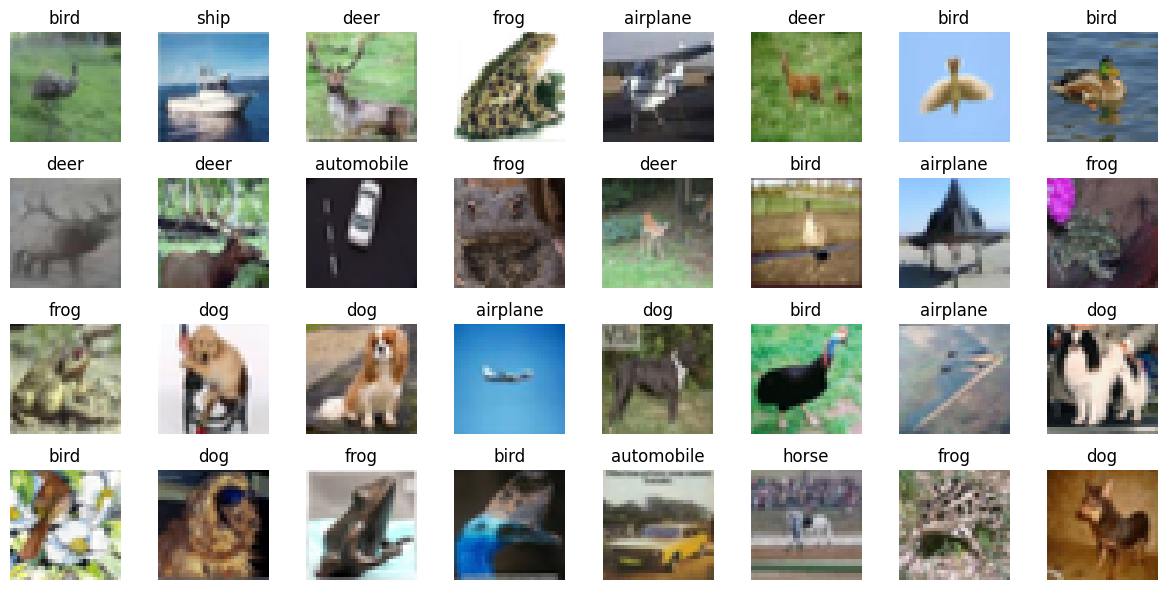

In [3]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy()
images = images / 2 + 0.5

fig, axs = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
                                   nn.Conv2d(3, 32, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.conv2 = nn.Sequential(
                                   nn.Conv2d(32, 64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.conv3 = nn.Sequential(
                                   nn.Conv2d(64, 64, 3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   )
        self.fc = nn.Sequential(
                                nn.Linear(1024, 64),
                                nn.ReLU(),
                                )
        self.clf = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x.flatten(1))
        return self.clf(x)


def train(mw, trainloader, epochs: int, device, verbose=TRAIN_VERBOSE):
    criterion = torch.nn.CrossEntropyLoss()
    epoch_loss_dict = []
    mw.initialize()
    mw.set_param()
    for i in range(1, epochs+1):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch in trainloader:
            mw.begin() # call this before each step, enables gradient tracking on desired params
            images, labels = batch["img"].to(device), batch["label"].to(device)
            outputs = mw.forward(images)
            loss = criterion(outputs, labels)
            mw.zero_grad()
            loss.backward(create_graph=True) # important! use create_graph=True
            mw.step()
            running_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        train_loss = running_loss / len(trainloader.dataset)
        epoch_loss_dict.append(train_loss)
        if verbose == True:
            print("EPOCH: {}, TRAIN LOSS: {}, ACCURACY: {}".format(i, train_loss, correct/total))


def test(model, testloader, device, verbose=TEST_VERBOSE):
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    running_loss = 0
    model.set_param()
    with torch.no_grad():
        for batch in testloader:
            image, label = batch["img"].to(device), batch["label"].to(device)
            output = model.forward(image)
            loss = criterion(output, label)
            running_loss += loss.item()
            total += label.size(0)
            correct += (torch.max(output.data, 1)[1] == label).sum().item()
        train_loss = running_loss / len(testloader.dataset)
    if verbose == True:
        print("EVAL LOSS: {}, ACCURACY: {}".format(train_loss, correct/total))
    
    return train_loss, correct/total


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]
    

In [5]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(net=self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] training")
        set_parameters(net=self.net, parameters=parameters)
        train(mw=self.net, trainloader=self.trainloader, epochs=3, device=DEVICE)
        return get_parameters(net=self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate")
        set_parameters(net=self.net, parameters=parameters)
        loss, accuracy = test(self.net, self.valloader, device=DEVICE)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    model = Net().to(DEVICE)
    optim = gdtuo.SGD(alpha=ALPHA, mu=MU, height=0)
    mw = gdtuo.ModuleWrapper(model, optimizer=optim)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, mw, trainloader, valloader).to_client()

In [6]:
class FedPopsicle(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedPopsicle"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        print("Initializing Parameters")
        model = Net().to(DEVICE)
        optim = gdtuo.SGD(alpha=ALPHA, mu=MU, height=0)
        mw = gdtuo.ModuleWrapper(model, optimizer=optim)
        mw.initialize()
        ndarrays_model = get_parameters(mw)
        return fl.common.ndarrays_to_parameters(ndarrays_model)

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated
    
    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        config = {}
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))
        return fit_configurations

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        accuracy_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.metrics['accuracy'])
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {"accuracy agg": float(accuracy_aggregated)}
        return loss_aggregated, metrics_aggregated
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""
        
        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [7]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=25),  # Just three rounds
    strategy=FedPopsicle(),
    client_resources=client_resources,
)

INFO flwr 2024-05-20 15:43:06,648 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
2024-05-20 15:43:10,238	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-05-20 15:43:13,322 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 2996045415.0, 'object_store_memory': 1498022707.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-05-20 15:43:13,323 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-05-20 15:43:13,323 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 0}
INFO flwr 2024-05-20 15:43:13,339 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2024-05-20 15:43:13,340 | server.py:89 | Initializing global parameters
INFO flwr 2024-05-20 15:43:13,354 | server.py:272 | Using initial parameters prov

Initializing Parameters


(pid=2948) WARNING:tensorflow:From c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.
(pid=2948) 
ERROR flwr 2024-05-20 15:43:29,163 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\

(DefaultActor pid=2948) [Client 5] training


ERROR flwr 2024-05-20 15:43:29,574 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 304, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
                                    ^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\ray\_private\auto_init_hook.

(DefaultActor pid=2948) [Client 6] training
(DefaultActor pid=2948) [Client 2] training


ERROR flwr 2024-05-20 15:43:29,987 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 304, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
                                    ^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\ray\_private\auto_init_hook.

(DefaultActor pid=2948) [Client 1] training


ERROR flwr 2024-05-20 15:43:30,184 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 304, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
                                    ^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\ray\_private\auto_init_hook.

(DefaultActor pid=2948) [Client 4] training


ERROR flwr 2024-05-20 15:43:30,419 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 304, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
                                    ^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\ray\_private\auto_init_hook.

(DefaultActor pid=2948) [Client 3] training


ERROR flwr 2024-05-20 15:43:30,628 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 423, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\flwr\simulation\ray_transport\ray_actor.py", line 304, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
                                    ^^^^^^^^
  File "c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\ray\_private\auto_init_hook.

(DefaultActor pid=2948) [Client 0] training
(DefaultActor pid=2948) [Client 4] evaluate
(DefaultActor pid=2948) [Client 2] evaluate
(DefaultActor pid=2948) [Client 1] evaluate
(DefaultActor pid=2948) [Client 5] evaluate
(DefaultActor pid=2948) [Client 3] evaluate
(DefaultActor pid=2948) [Client 6] evaluate
(DefaultActor pid=2948) [Client 0] evaluate


DEBUG flwr 2024-05-20 15:43:35,810 | server.py:187 | evaluate_round 1 received 7 results and 0 failures
DEBUG flwr 2024-05-20 15:43:35,811 | server.py:222 | fit_round 2: strategy sampled 7 clients (out of 7)


(DefaultActor pid=2948) [Client 5] training


(DefaultActor pid=2948) c:\Users\poops\Desktop\Coding Shenanigans\SOIEvent\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1208.)
(DefaultActor pid=2948)   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


(DefaultActor pid=2948) [Client 3] training
(DefaultActor pid=2948) [Client 1] training
